# Introdução

- Ambev
- KPI

# Inicialização

Carregamos a seguir as bibliotecas utilizadas.

In [1]:
# Import de bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyxlsb import open_workbook as open_xlsb

%matplotlib inline

data_xlsb = '../data/ambev.xlsb'

In [2]:
# Executar se pyxlsb não tiver instalado
#!pip install pyxlsb
#from pyxlsb import open_workbook as open_xlsb

# Leitura/Limpeza dos dados

Incluímos aqui nessa seção os passos de tratamento do conjunto de dados realizados no notebook de exploração `AmBev_Data_Wrangling`. Algumas explicações são omitidas aqui, de modo a manter o notebook mais enxuto. Para mais detalhes sobre os passos realizados, favor consultar `AmBev_Data_Wrangling.ipynb`.

Definimos funções auxiliares para realizar a limpeza dos dados.

In [3]:
import unidecode

# Função para substituir espaços por _ (utilizado nos nomes de colunas)
def str_replace_spaces(input_str):
    if input_str == None: return None
    else: return input_str.replace(' ','_')

# Função para 'sanitizar' strings, substituindo erros inseridos por encoding
def str_sanitize(input_str):
    if not (isinstance(input_str,str)):
        return input_str
    
    output_str = input_str.replace('Á¡', 'á')
    
    return unidecode.unidecode(output_str)

# Função que recebe valores de uma linha 'suja' (com valores de Regra Alcance Parcial em mais de uma coluna) 
# e retorna uma linha 'limpa'.
def list_sanitize(input_list):
    output_list = []
    read_val = False
    
    for i, a in enumerate(input_list):
        if i == 21: 
            val = a
            if val != None: val = str(val)
        elif i == 22:
            if a != None \
            and not re.search('Sim',a) \
            and not re.search('Não',a):
                read_val = True
                val += " " + a
            else:
                output_list.append(val)
                output_list.append(a)
        
        else:
            if read_val:
                if a == None:
                    read_val = False
                    output_list.append(val)
                    output_list.append(a)
                    
                if re.search('\"$',str(a)):
                    read_val = False
                    val += " " + a
                    output_list.append(val)
                    
                    
            else:
                output_list.append(a)
                
    return output_list

Definidas as funções auxiliares, vamos realizar a leitura dos dados. Note que: valores ausentes são preenchidos com `nan`, para evitar valores `None` no dataframe; as últimas colunas (vazias) são removidas; e `Mes_Referencia` é tratado como `datetime`, no formato Mês + Ano.

In [4]:
df = []

with open_xlsb(data_xlsb) as wb:
    for sheetname in wb.sheets:
        with wb.get_sheet(sheetname) as sheet:  
            for i,row in enumerate(sheet.rows()):
                row_li = [item.v for item in row]
                if (i>0): row_li = list_sanitize(row_li)
                elif (i==0): row_li = [str_sanitize(str_replace_spaces(item)) for item in row_li]
                df.append(row_li)
                
df = pd.DataFrame(df[1:], columns=df[0])
df.drop(df.columns[-5:-1],axis=1,inplace=True)
df['Mes_Referencia'] = pd.to_datetime(df['Mes_Referencia'], format='%m%Y.0')
df['Banda'] = df['Banda'].apply(lambda x : str(x).upper() if (x != 'Blue Collars' and x != None) else x)

Vejamos como ficou o dataframe.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270633 entries, 0 to 270632
Data columns (total 33 columns):
Mes_Referencia           270633 non-null datetime64[ns]
Pais                     270633 non-null object
Mundo                    270501 non-null object
Regional/Area            270633 non-null float64
Unidade                  270633 non-null float64
Grupo_Cargo              230099 non-null object
Cargo                    262118 non-null object
Grade                    262118 non-null float64
Banda                    262118 non-null object
Area                     262116 non-null object
Nome_Funcionario         270633 non-null float64
Nome_Gestor              270633 non-null float64
Codigo_KPI               230229 non-null object
Diretoria                230229 non-null object
Areas_da_Diretoria       230229 non-null object
Funcao                   230229 non-null object
Tipo_da_Meta             270633 non-null object
Categoria_KPI            267176 non-null object
Nome_KPI    

Criamos um dicionário para substituir erros gerais na codificação, e definimos uma função para realizar a limpeza adicional.

In [6]:
replace_dict = {'Áµ':'õ',
                'Ã`\x01': 'Ê',
                'Ã\x8d': 'Í',
                'Ã! ':'Ç',
                'Ã\x92\x01O': 'ÃO',
                'Á\x1d ': 'Ô',
                'Á\x1c': 'Ó', 
                'Á\x8d': 'Í',
                'Â\xa0': ' ',
                '\x81':'',
                'â¬ \x1c ': '-', 
                'Á¡':'á',
                'Ã©': 'é',
                'Ã\xad': 'í',
                'Ã\x1c': 'Ó',
                'Ã£': 'ã',
                'ARMAZÁ0 M': 'ARMAZÉM',
                'OPERAçÁ" ES': 'OPERAçÕES',
                'Logisitca': 'Logistica',
                'Sumistros': 'Suministros',
                'GREG': 'GER'
               }

def str_clean(x):
    if x == None or not isinstance(x,str): return x
    for item in replace_dict:
        if item in x:
            x = x.replace(item,replace_dict[item])
            
    return unidecode.unidecode(x).strip()

Aplicamos a função aos campos que têm string. Além disso, usamos a função `title` para algumas categorias.

In [7]:
for col in df.columns:
    if (df[col].dtype=='O'):
        df[col] = df[col].apply(lambda x : str_clean(x))

cols = ['Grupo_Cargo', 'Area', 'Funcao', 'Categoria_KPI']
for col in cols:
    df[col] = df[col].apply(lambda x : x.title() if x != None else x)

Para refinar a limpeza, e remover inconsistências específicas a cada feature, aplicamos a função abaixo.

In [8]:
replace_dict_cat = {
    'Area': [
        ['E-Commerce', 'Ecommerce'],
        ['Projeto', 'Projetos']
    ],
    
    'Funcao': [
        ['Gerente Financeiro', 'Ger Financeiro']
    ],
    
    'Categoria_KPI': [
        ['Imagen De Mnarca', 'Imagen De Marca'],
        ['Machine Kpis', 'Machine Kpi'],
        ['Cash Flow','Cashflow'],
        ['Project Kpi', 'Project'],
        ['Le Accurancy', 'Le Accuracy'],
        ['Legal Compliance', 'Compliance'],
        ['Gestio N Recursos Marcas', 'Gestion Recursos Marcas']
        
    ],
    
    
    'Prazo': [
        ['monthly', 'Monthly'],
        ['Monthly basis', 'Monthly'],
        ['monthly basis', 'Monthly']
    ]
}

def str_refinement(df):
    for cat in replace_dict_cat:
        for [str_from,str_to] in replace_dict_cat[cat]:
            df[cat].replace(str_from,str_to,inplace=True)
            
str_refinement(df)

Agrupamos então strings similares dentro de uma mesma feature.

In [9]:
from difflib import SequenceMatcher

# Função de similaridade
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()    

# Função para agrupar as diferentes versões de strings em uma coluna
def str_similarity_replacement(df,col):
    replacement_dict = {}
    
    enum = list(enumerate(df[col].unique()))
    for i, a in enum:
        for j,b in enum:
            if (j > i) and (isinstance(a,str)) and (isinstance(b,str)) and (similar(a,b) > 0.7):
                if b not in replacement_dict: replacement_dict[b] = a
                
    for b in replacement_dict:
        a = replacement_dict[b]
        while (a in replacement_dict):
            a = replacement_dict[a]
        replacement_dict[b] = a
        
    for b in replacement_dict:
        df[col].replace(b, replacement_dict[b],inplace=True)
        
        
str_similarity_replacement(df,'Categoria_KPI')

O trabalho que não pôde ser realizado automaticamente pelo agrupamento é então realizado manualmente.

In [75]:
def sanitize_cat_kpi(df):
    col = 'Categoria_KPI'
    
    df[col] = df[col].apply(lambda x: re.sub(r'\s*/\s*', r'/', x).strip() if x != None else x)
    
    replace_dict = {
        'Continuous Improvement': 'Melhoria Continua',
        'People & Management': 'Gente E Gestao',
        'Imagem Da Marca (Brandhealth)': 'Imagem Da Marca',
        'Brand Health' : 'Imagem Da Marca',
        'Innovations/Innovations Project': 'Inovacoes/Projeto De Inovacoes',
        'Quality': 'Qualidade',
        'Imagen De Marca': 'Imagem Da Marca',
        'Rentabilidade/Custos (Maco, Vic, Vlc, Ebitda, Eficiencia E Produtividade)': 'Rentabilidade/Custos',
        'Rentabilidad/Costos': 'Rentabilidade/Custos',
        'Better World' : 'Mundo Melhor',
        'Innovaciones': 'Inovacoes/Projeto De Inovacoes',
        'Profit/Costs (Maco,Vic, Vlc, Ebitda..)': 'Rentabilidade/Custos',
        'Long-Term Projects/Initiatives/Strategy': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Volumen': 'Market Share/Volume',
        'Ebitda': 'Rentabilidade/Custos',
        'Productivity': 'Rentabilidade/Custos',
        'Cost': 'Rentabilidade/Custos',
        'Gestion': 'Gente E Gestao',
        'Sinergias Caribe': 'Sinergias',
        'Synergies': 'Sinergias',
        'People': 'Gente E Gestao',
        'Reputacion': 'Imagem Da Marca',
        'Project': 'Projetos/Iniciativas De Longo Prazo/Estrategia',
        'Safety': 'Seguranca',
        'Seguridad': 'Seguranca',
        'Obz': 'OBZ',
        'Zbb': 'OBZ',
        'Obz Incentivos': 'OBZ',
        'Reporte De Carga Tendencias Obz': 'OBZ',
        'Vpo Sustentable - Management And People Pilar': 'Gente E Gestao',
        'Dpo': 'DPO',
        'Machine Kpi': 'Machine KPI',
        'Rojo+Negro Equipo Frio': 'Equipo Frio',
        'Reporte Equipo Frio Rojo+Negro': 'Equipo Frio',
        'Asistente De Nomica': 'Cashflow',
        'Cumplimiento': 'Compliance'
    }
    
    for a in replace_dict:
        df[col].replace(a, replace_dict[a], inplace=True)
    
    
    
    
sanitize_cat_kpi(df)

In [12]:
df.fillna(value=pd.np.nan, inplace=True)
df.replace('None', np.nan, inplace=True)

In [14]:
df.head()

,Mes_Referencia,Pais,Mundo,Regional/Area,Unidade,Grupo_Cargo,Cargo,Grade,Banda,Area,...,%_Ating_Mes,%_Pontos_Mes,%_Acum_Mes,%_Ating_Acumulado,%_Pontos_Acumulado,%_Acum_Acumulado,%_Ating_Fim_Exer,%_Pontos_Fim_Exer,%_Acum_Fim_Exer,Status_Meta
0,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,25.0,Monitoramento Aprovado
1,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,80.0,60.0,12.0,80.0,60.0,12.0,100.0,100.0,20.0,Monitoramento Aprovado
3,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,100.0,100.0,15.0,90.0,80.0,12.0,100.0,100.0,15.0,Monitoramento Aprovado
4,2017-03-01,Brasil,Sales,10.0,78.0,Ger De Vendas Revenda,GERENTE DE VENDAS REVENDA II,12.0,VI-B,Gerencia Cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Aqui se encerra a etapa de Limpeza/Manipulação dos dados feita anteriormente. A seguir, dividimos as colunas em classes, de modo a facilitar a exploração.

In [15]:
# Variáveis categóricas
category = [
    'Pais',
    'Mundo',
    'Grupo_Cargo',
    'Cargo',
    'Nome_Funcionario',
    'Nome_Gestor',
    'Codigo_KPI',
    'Diretoria',
    'Areas_da_Diretoria',
    'Funcao',
    'Tipo_da_Meta',
    'Categoria_KPI',
    'Nome_KPI',
    'Meta_Projeto',
    'Status_Meta'
]

# Variáveis binárias
binary = [    
]

# Variáveis numéricas de valor inteiro
integral = [
    'Regional/Area',
    'Grade',
    'Peso_KPI',
    'Unidade',
    '%_Ating_Mes', 
    '%_Pontos_Mes', 
    '%_Acum_Mes', 
    '%_Ating_Acumulado', 
    '%_Pontos_Acumulado', 
    '%_Acum_Acumulado', 
    '%_Ating_Fim_Exer', 
    '%_Pontos_Fim_Exer', 
    '%_Acum_Fim_Exer'
]

# Variáveis numéricas de valor contínuo
continuous = [
]

# Demais tipos de variáveis
timestamp = ['Mes_Referencia','Prazo']
rule = ['Regra_Alcance_Parcial']

# Convertemos as categorias
df[category] = df[category].astype('category')

# Convertemos os valores inteiros
# Por limitação do Pandas/Numpy, valores inteiros tratados como float devido à presença de NaN
integral_as_int = []
integral_as_float = []

for col in integral:
    if not (df[col].isnull().values.any()):
        df[col] = df[col].astype('int')
        integral_as_int.append(col)
    else:
        df[col] = df[col].astype('float')
        integral_as_float.append(col)


In [16]:
integral_as_float

['Grade',
 '%_Ating_Mes',
 '%_Pontos_Mes',
 '%_Acum_Mes',
 '%_Ating_Acumulado',
 '%_Pontos_Acumulado',
 '%_Acum_Acumulado',
 '%_Ating_Fim_Exer',
 '%_Pontos_Fim_Exer',
 '%_Acum_Fim_Exer']

# Exploração dos dados

## Estatísticas básicas

### Valores únicos

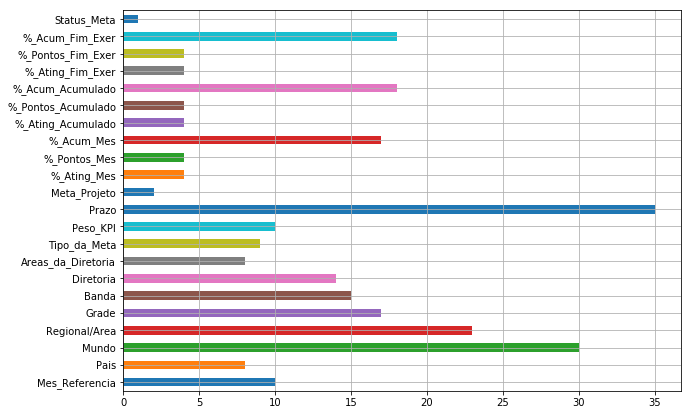

In [207]:
plt.figure(figsize=(10,7))
(df.loc[:, df.apply(lambda x: x.nunique()) < 50]).nunique().plot(kind='barh')
plt.grid()

### Demais

Text(0.5, 0, 'Quantidade (contagem)')

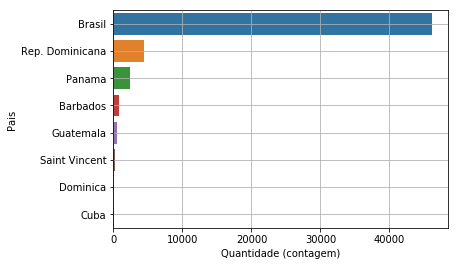

In [214]:
to_plot = 'Pais'
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade (contagem)')

Text(0.5, 0, 'Quantidade (contagem)')

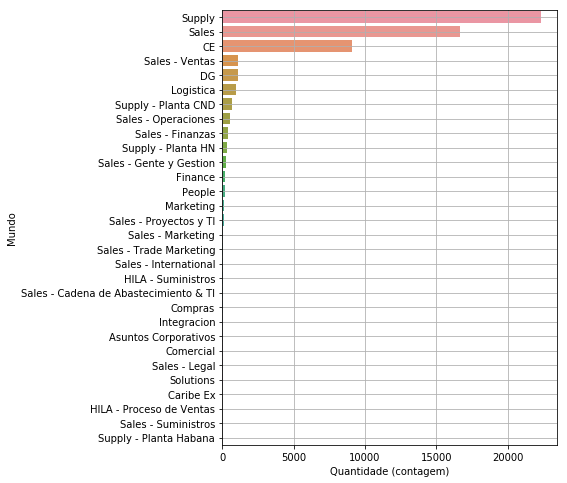

In [213]:
plt.figure(figsize=(6,8))
to_plot = 'Mundo'
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)

plt.grid()
plt.xlabel('Quantidade (contagem)')

Text(0.5, 0, 'Quantidade (contagem)')

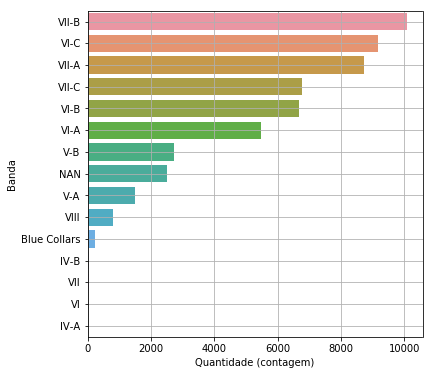

In [212]:
plt.figure(figsize=(6,6))
to_plot = 'Banda'
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade (contagem)')

Text(0.5, 0, 'Quantidade (contagem)')

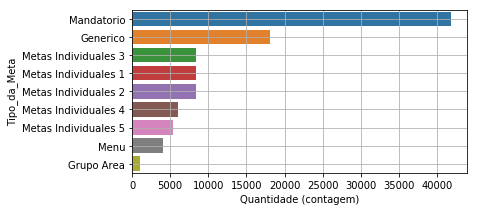

In [211]:
plt.figure(figsize=(6,3))
to_plot = 'Tipo_da_Meta'
sns.countplot(y=to_plot,
              data=df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot]),
            order = df.drop_duplicates(['Nome_Funcionario','Mes_Referencia', to_plot])[to_plot].value_counts().index)
plt.grid()
plt.xlabel('Quantidade (contagem)')

## Valores ausentes

### Status Meta

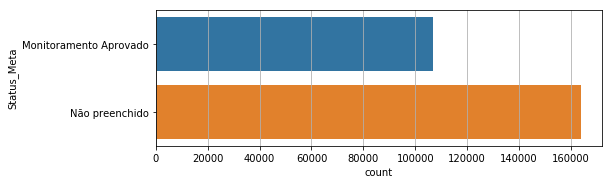

In [141]:
plt.figure(figsize=(8,2.5))
plt.grid()
meta_nan = 'Não preenchido'
#df['Status_Meta'] = df['Status_Meta'].cat.add_categories(meta_nan)

sns.countplot(y=df['Status_Meta'].fillna(meta_nan))

In [87]:
len(df[~df['Status_Meta'].isna()])/len(df)*100

39.43052029870711

### Categoria KPI

Analisando as entradas que não possuem valores na feature `Categoria_KPI`, percebemos que todos se concentram na 'Regional/Area' de número 4, além do fato de que nestes casos as colunas de porcentagens de pontos relacionadas a metas de KPI só possuem valores 0 ou não foram preenchidas.
Vejamos então as proporções com que cada Regional deixou de preencher dados de KPI.

In [20]:
for col in df.columns:
    print(col)
    print(df[df['Categoria_KPI'].isna()][col].unique())

Mes_Referencia
['2017-06-01T00:00:00.000000000' '2017-07-01T00:00:00.000000000'
 '2017-08-01T00:00:00.000000000' '2017-09-01T00:00:00.000000000'
 '2017-10-01T00:00:00.000000000' '2017-11-01T00:00:00.000000000'
 '2017-12-01T00:00:00.000000000']
Pais
[Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Categories (6, object): [Barbados, Cuba, Dominica, Guatemala, Panama, Rep. Dominicana]
Mundo
[Supply, Sales, Finance, Integracion, Marketing, ..., Sales - Proyectos y TI, Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Length: 24
Categories (24, object): [Supply, Sales, Finance, Integracion, ..., Sales - Suministros, Sales - Trade Marketing, Supply - Planta CND, Asuntos Corporativos]
Regional/Area
[4]
Unidade
[ 16  17 257 279 264 258 305 306 315 328 329  47  50  56  69 113 147 159
 160 161 165 265 290 292 312 325 316]
Grupo_Cargo
[NaN]
Categories (0, object): []
Cargo
[NaN, GER DE TRADE MKTG ROTA III, COORDENADOR JR, ANALISTA II, ESPECIALI

Text(0, 0.5, 'Regional/Area')

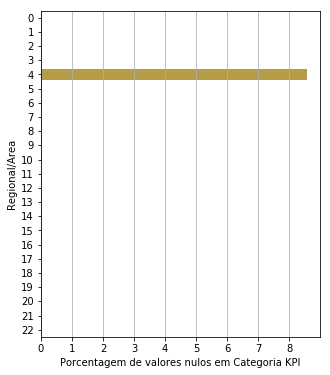

In [46]:
vals = []
for a in sorted(df['Regional/Area'].unique()):
    vals.append([a,100*len(df[df['Categoria_KPI'].isna() & (df['Regional/Area']==a)])/len(df[(df['Regional/Area']==a)])])
    
plt.figure(figsize=(5,6))
plt.grid()
sns.barplot(y=[i[0] for i in vals], x=[i[1] for i in vals], orient="h")
plt.xlabel("Porcentagem de valores nulos em Categoria KPI")
plt.ylabel("Regional/Area")

A partir do gráfico, vemos que todas Áreas preencheram integralmente os valores de Categoria de KPI, exceto pela 4. Esta deixou de fazê-lo em pouco mais de 8% das entradas fornecidas.

## Categoria KPI

### Principais categorias

In [ ]:
# Operações a serem realizadas
oper = ['mean', 'std']

# Colunas a serem agrupadas
kpi_cols = {'Peso_KPI' : oper + ['count']} 
for col in df.columns:
    if re.search('^%_',col):
        kpi_cols[col] = oper

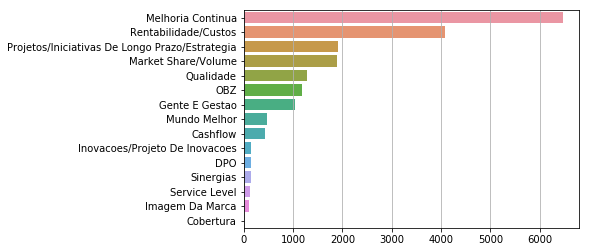

In [180]:
# Criamos então o dataframe agregando as features por categoria        
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Categoria_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())

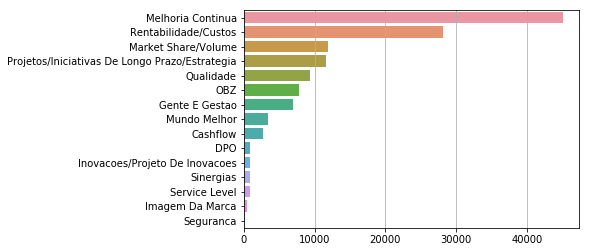

In [182]:
# Criamos outro dataframe, agregando as features por categoria, mas considerando também os meses    
agg_df = df[~df['Categoria_KPI'].isna()].\
        drop_duplicates(['Nome_Funcionario', 'Mes_Referencia', 'Categoria_KPI']).groupby('Categoria_KPI').\
                        agg(kpi_cols)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]

plt.grid()
sns.barplot(x=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].values.tolist(), 
            y=agg_df.sort_values('Peso_KPI_count', ascending=False)['Peso_KPI_count'][:15].index.values.tolist())

/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


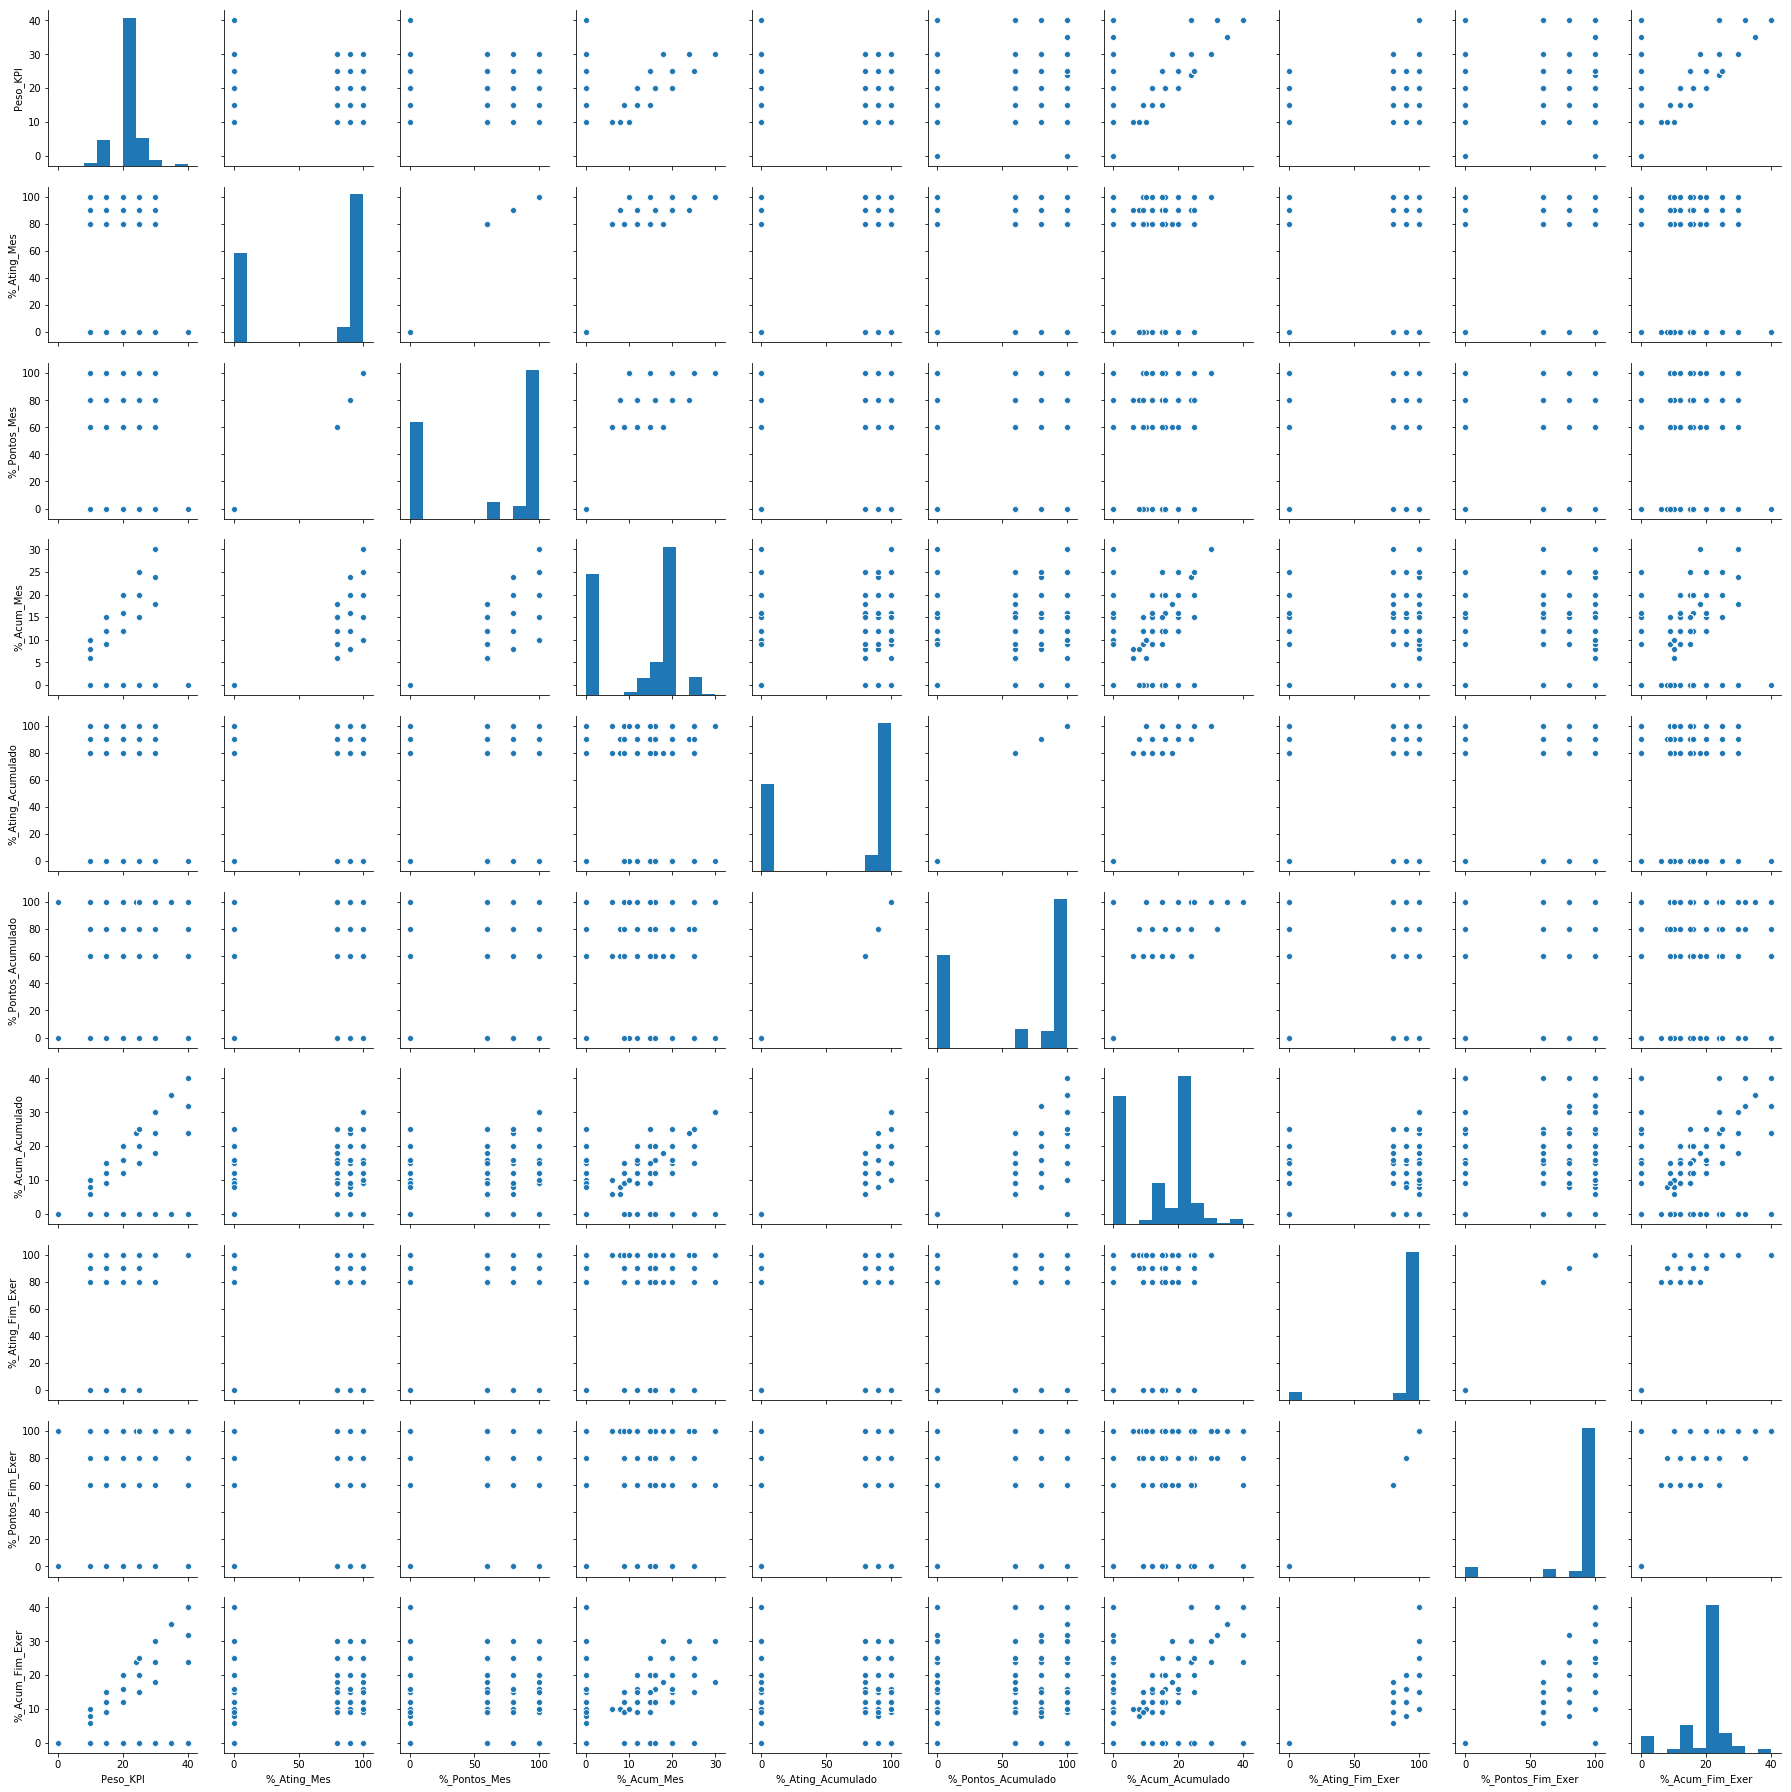

In [154]:
sns.pairplot(df[df['Categoria_KPI'].isin(main_kpi_cols)].\
        drop_duplicates(['Nome_Funcionario', 'Categoria_KPI'])[list(kpi_cols.keys())]);

# Draft

/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/anaconda2/envs/challenge/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


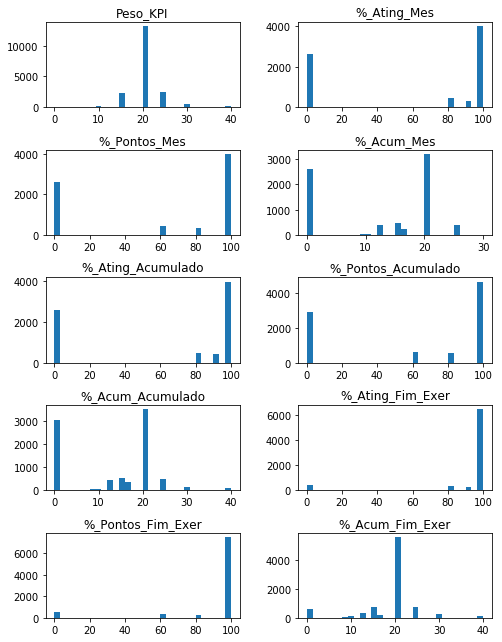

In [242]:
fig = plt.figure(figsize=(8,18))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

for i,col in enumerate(list(kpi_cols.keys())):
    ax = fig.add_subplot(8, 2, i+1)
    ax.title.set_text(col)
    #fig.suptitle('Main title')
    ax.hist(df[df['Categoria_KPI'].isin(main_kpi_cols)].\
        drop_duplicates(['Nome_Funcionario', 'Categoria_KPI'])[col],bins=30)
    

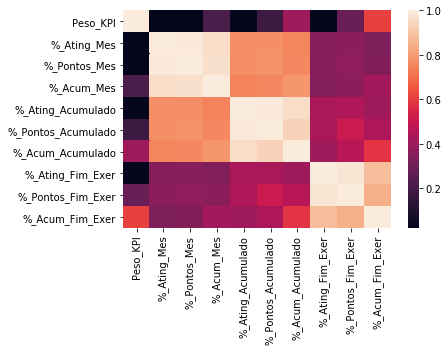

In [222]:
corr = df[list(kpi_cols.keys())].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Total de valores

In [261]:
df[~df['%_Ating_Mes'].isna() & ~df['%_Pontos_Mes'].isna()].shape[0]

106285

Vemos abaixo:
- Pontos <= Ating
- Pontos * Peso_KPI/100 = Acum

In [263]:
df[df['%_Ating_Mes'] >= df['%_Pontos_Mes']].shape[0]

106285

In [262]:
df[~df['%_Pontos_Mes'].isna() &
    (df['%_Pontos_Mes']*df['Peso_KPI']/100==df['%_Acum_Mes'])].shape[0]

106285

Porcentagem de metas cumpridas integralmente.

In [255]:
for kpi_period in ['Mes', 'Acumulado', 'Fim_Exer']:
    print(kpi_period + ': ' + str((df[df['%_Ating_'+kpi_period] == df['%_Pontos_'+kpi_period]].shape[0]\
           /df[df['%_Ating_'+kpi_period] >= df['%_Pontos_'+kpi_period]].shape[0])*100))

Mes: 88.11873735710589
Acumulado: 86.43732663617962
Fim_Exer: 90.22977734462853


In [260]:
for m in list(df['Mes_Referencia'].unique()):
    print(m)
    print(df[df['Mes_Referencia']==m].shape)

2017-03-01T00:00:00.000000000
(20944, 33)
2017-04-01T00:00:00.000000000
(23456, 33)
2017-05-01T00:00:00.000000000
(22913, 33)
2017-06-01T00:00:00.000000000
(28361, 33)
2017-07-01T00:00:00.000000000
(27625, 33)
2017-08-01T00:00:00.000000000
(28620, 33)
2017-09-01T00:00:00.000000000
(28271, 33)
2017-10-01T00:00:00.000000000
(29226, 33)
2017-11-01T00:00:00.000000000
(30504, 33)
2017-12-01T00:00:00.000000000
(30713, 33)


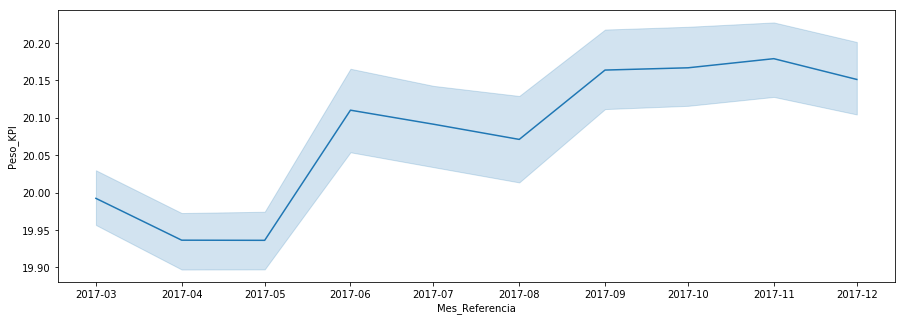

In [273]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Mes_Referencia", y="Peso_KPI",
             #hue="region", style="event",
             data=df)

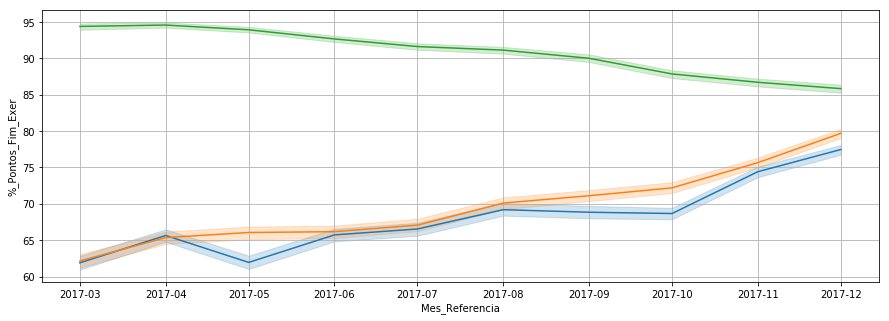

In [283]:
plt.figure(figsize=(15,5))
sns.lineplot(x="Mes_Referencia", y="%_Pontos_Mes",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()])

sns.lineplot(x="Mes_Referencia", y="%_Pontos_Acumulado",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()])

sns.lineplot(x="Mes_Referencia", y="%_Pontos_Fim_Exer",
             #hue="region", style="event",
             data=df[~df['%_Pontos_Mes'].isna() & ~df['%_Pontos_Acumulado'].isna() & ~df['%_Pontos_Fim_Exer'].isna()])

plt.grid()